# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


In [2]:
#Analized breed dog
list_breed = [(item.split('/')[2], len(glob(f"{item}/*"))) for item in sorted(glob("dogImages/train/*/"))]
print("List breed in train folder")
print("Dog Breed \t Count")
for b, count in list_breed:
    print(f"{b} \t\t {count}")

List breed in train folder
Dog Breed 	 Count
001.Affenpinscher 		 64
002.Afghan_hound 		 58
003.Airedale_terrier 		 52
004.Akita 		 63
005.Alaskan_malamute 		 77
006.American_eskimo_dog 		 64
007.American_foxhound 		 50
008.American_staffordshire_terrier 		 66
009.American_water_spaniel 		 34
010.Anatolian_shepherd_dog 		 50
011.Australian_cattle_dog 		 66
012.Australian_shepherd 		 66
013.Australian_terrier 		 46
014.Basenji 		 69
015.Basset_hound 		 73
016.Beagle 		 59
017.Bearded_collie 		 62
018.Beauceron 		 50
019.Bedlington_terrier 		 48
020.Belgian_malinois 		 62
021.Belgian_sheepdog 		 64
022.Belgian_tervuren 		 47
023.Bernese_mountain_dog 		 65
024.Bichon_frise 		 62
025.Black_and_tan_coonhound 		 37
026.Black_russian_terrier 		 41
027.Bloodhound 		 64
028.Bluetick_coonhound 		 35
029.Border_collie 		 74
030.Border_terrier 		 52
031.Borzoi 		 56
032.Boston_terrier 		 65
033.Bouvier_des_flandres 		 45
034.Boxer 		 64
035.Boykin_spaniel 		 53
036.Briard 		 65
037.Brittany 		 50


MIN number of train file for breed: 77
MAX number of train file for breed: 26


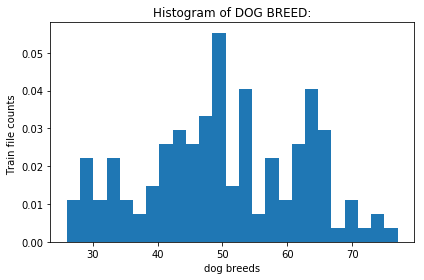

In [3]:
import matplotlib.pyplot as plt                        
%matplotlib inline         

#Hist
num_bins = 25
fig, ax = plt.subplots()

cached_list_bred = [l[1] for l in list_breed]

print(f"MIN number of train file for breed: {max(cached_list_bred)}")
print(f"MAX number of train file for breed: {min(cached_list_bred)}")

n, bins, patches = ax.hist(cached_list_bred, num_bins, density=1)

ax.set_xlabel('dog breeds')
ax.set_ylabel('Train file counts ')
ax.set_title(r'Histogram of DOG BREED:')

# Tweak spacing to prevent clipping of ylabel
fig.tight_layout()
plt.show()

<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


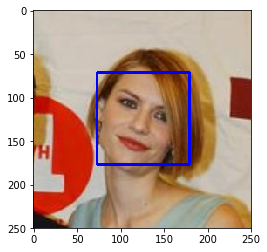

In [4]:
import cv2                
from random import randint

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[randint(0, len(human_files))])  #a random face
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
* 98% of human_files(first 100) detected a human face.
* 10% of dog_files(first 100) detected a human face.

In [6]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

fc_human = [face_detector(h) for h in human_files_short]
fc_dog = [face_detector(d) for d in dog_files_short]

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

fc_human_p = sum(fc_human)/len(fc_human) * 100
fc_dog_p = sum(fc_dog)/len(fc_dog) * 100

print(f"Founded {int(fc_human_p)} % on first {len(fc_human)} human faces")
print(f"Founded {int(fc_dog_p)} % on first {len(fc_dog)} dog images")

Founded 98 % on first 100 human faces
Founded 10 % on first 100 dog images


Faces False negative
Number of faces detected: 0


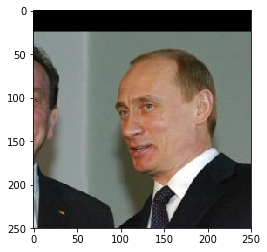

Number of faces detected: 0


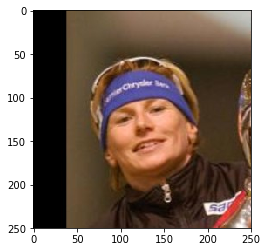

In [33]:
print("Faces False negative")
for i, pred_face in enumerate(fc_human):
    if not pred_face:
        img = cv2.imread(human_files_short[i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray)
        print('Number of faces detected:', len(faces))

        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(cv_rgb)
        plt.show()

Dogs faces false positive
Number of faces detected: 1


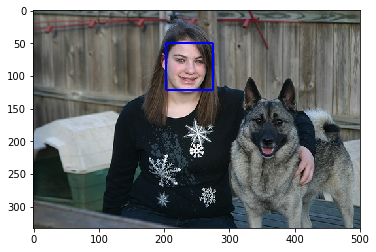

Number of faces detected: 2


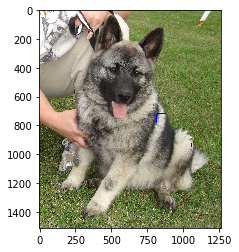

Number of faces detected: 2


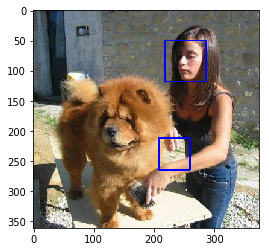

Number of faces detected: 1


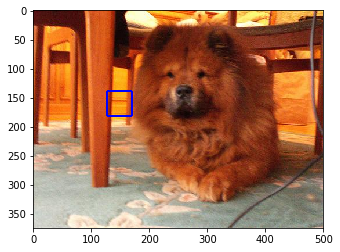

Number of faces detected: 1


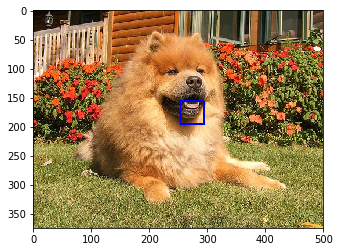

Number of faces detected: 1


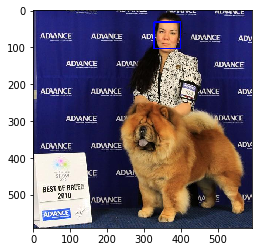

Number of faces detected: 1


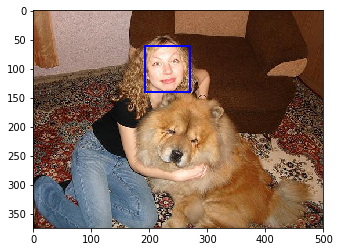

Number of faces detected: 1


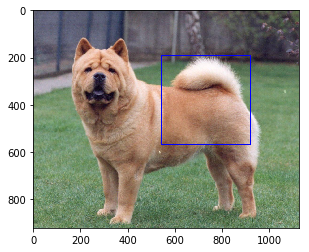

Number of faces detected: 1


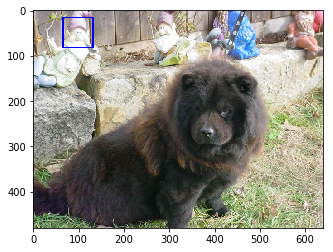

Number of faces detected: 1


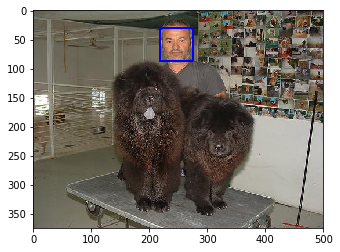

In [8]:
print("Dogs faces false positive")
for i, pred_face in enumerate(fc_dog):
    if pred_face:
        img = cv2.imread(dog_files_short[i])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray)
        print('Number of faces detected:', len(faces))

        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.imshow(cv_rgb)
        plt.show()

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [35]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

## Testing FaceNet pretrained model 
(https://github.com/timesler/facenet-pytorch)

FaceNet ss a Inception Resnet (V1) models in pytorch, pretrained on VGGFace2.

In [36]:
#installing the library
!pip install facenet-pytorch

    100% |████████████████████████████████| 1.9MB 18.2MB/s ta 0:00:01
fastai 1.0.60 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [9]:
from facenet_pytorch import MTCNN, InceptionResnetV1

#resnet model in inference mode
#res_face_model = InceptionResnetV1(pretrained='vggface2').eval()
mtcnn = MTCNN(
    image_size=250, margin=0
)

In [10]:
from PIL import Image
THRESHOLD = 0.98

def face_detector_resnet(mtcnn, image_path):
    img = Image.open(image_path)
    img_cropped, prob = mtcnn(img, return_prob=True)
    
    return prob > THRESHOLD if prob else False

    ####return embeddings
    #resnet_model.classify = True
    #return resnet_model(img_cropped.unsqueeze(0))
    
def face_detector_resnet_prob(mtcnn, image_path):
    img = Image.open(image_path)
    img_cropped, prob = mtcnn(img, return_prob=True)
    
    return prob

In [11]:
fc_human_resnet = [face_detector_resnet(mtcnn, h) for h in human_files_short]
fc_dog_resnet = [face_detector_resnet(mtcnn, d) for d in dog_files_short]

fc_human_p_resnet = sum(fc_human_resnet)/len(fc_human_resnet) * 100
fc_dog_p_resnet = sum(fc_dog_resnet)/len(fc_dog_resnet) * 100

print(f"Facenet -> Founded {int(fc_human_p_resnet)} % on first {len(fc_human_resnet)} human faces")
print(f"Facenet -> Founded {int(fc_dog_p_resnet)} % on first {len(fc_dog_resnet)} dog images")

Facenet -> Founded 99 % on first 100 human faces
Facenet -> Founded 8 % on first 100 dog images


Facenet on faces have good performaces with a high threshold. And on dog images because he find human faces inside images.

Dogs faces false positive with FACENET
Probability: 0.99999774


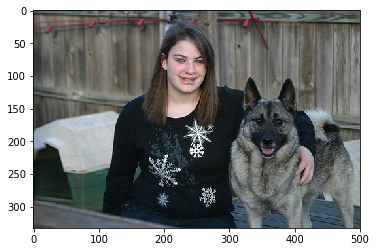

Probability: 0.999866


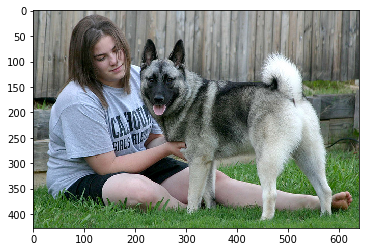

Probability: 0.99998975


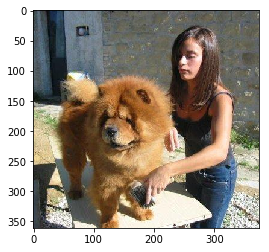

Probability: 0.99986005


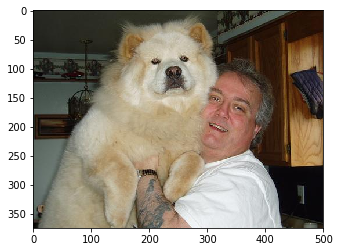

Probability: 0.99946123


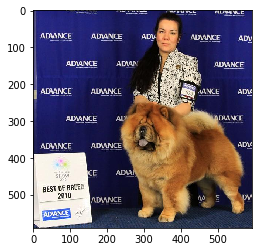

Probability: 0.98364913


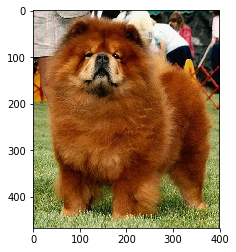

Probability: 0.999701


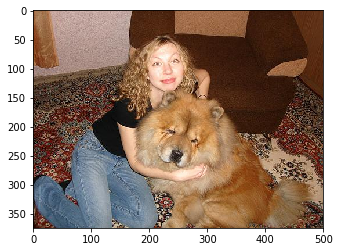

Probability: 0.9996094


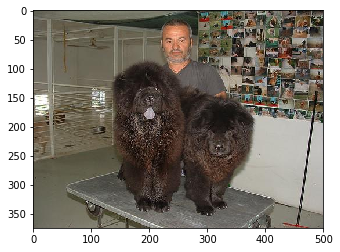

In [12]:
print("Dogs faces false positive with FACENET")
for i, pred_face in enumerate(fc_dog_resnet):
    if pred_face:
        prob = face_detector_resnet_prob(mtcnn, dog_files_short[i])
        print('Probability:', prob)
        img = cv2.imread(dog_files_short[i])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

In [13]:
#destroy facenet model
del mtcnn

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [14]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True, progress=False)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [15]:
from PIL import Image
import torchvision.transforms as T

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path).convert('RGB')
    #from https://pytorch.org/docs/stable/torchvision/models.html
    normalize = T.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
    transformator = T.Compose([T.Resize(256), T.CenterCrop(224), T.ToTensor()])
    transformed_image = transformator(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        transformed_image = transformed_image.cuda()
    
    output = VGG16(transformed_image)
    #print(torch.max(output,1)[1])
    return torch.max(output,1)[1].item() 

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [16]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):    
    predicted_index = VGG16_predict(img_path)
    return predicted_index >=151 and predicted_index <=268 # true/false


### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 
* On *human_file_short* 0 Dog was founded.
* On *dog_files_short* was founded 98 dog images on 100. 

Vgg have very good performance on finding dog.

In [17]:
from tqdm.notebook import tqdm

### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

print("VGG Dog detector on human_files_short")
fc_human_vgg = [dog_detector(h) for h in tqdm(human_files_short)]
print("VGG Dog detector on dog_files_short")
fc_dog_vgg = [dog_detector(d) for d in tqdm(dog_files_short)]

fc_human_vgg_p = sum(fc_human_vgg)/len(fc_human_vgg) * 100
fc_dog_vgg_p = sum(fc_dog_vgg)/len(fc_dog_vgg) * 100

print(f"VGG dog detector -> Founded {int(fc_human_vgg_p)} % on first {len(fc_human_vgg)} human faces")
print(f"VGG dog detector -> Founded {int(fc_dog_vgg_p)} % on first {len(fc_dog_vgg)} dog images")


VGG Dog detector on human_files_short



VGG Dog detector on dog_files_short



VGG dog detector -> Founded 0 % on first 100 human faces
VGG dog detector -> Founded 98 % on first 100 dog images


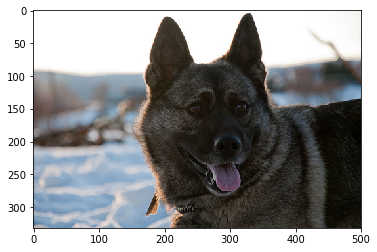

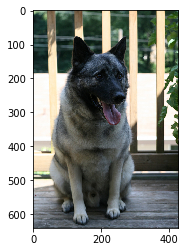

In [21]:
#Check the False negative on dogs images

for i, value_classification in enumerate(fc_dog_vgg):
    if not value_classification:
        img = cv2.imread(dog_files_short[i])
        cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()

We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [22]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
del VGG16

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [1]:
import os
from torchvision import datasets
import torchvision.transforms as T

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

BASE_FOLDER = 'dogImages'
BATCH_SIZE = 8
NUM_WORKERS = int(os.cpu_count() / 2) if int(os.cpu_count() / 2) > 0 else 1


#see https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

train_data_transform = T.Compose([
        T.Resize(size=(224,224)),
        #T.RandomSizedCrop(224),
        T.RandomHorizontalFlip(),
        T.RandomRotation(90),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

#for valid and test no transformation
test_data_transform = T.Compose([
        T.Resize(size=(224,224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_dataset = datasets.ImageFolder(root=f'{BASE_FOLDER}/train',
                                           transform=train_data_transform)
validation_dataset = datasets.ImageFolder(root=f'{BASE_FOLDER}/valid',
                                           transform=test_data_transform)
test_dataset = datasets.ImageFolder(root=f'{BASE_FOLDER}/test',
                                           transform=test_data_transform)


In [2]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, 
                              batch_size=BATCH_SIZE, 
                              num_workers=NUM_WORKERS, 
                              shuffle = True)
val_dataloader = DataLoader(validation_dataset, 
                            batch_size=BATCH_SIZE, 
                            num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, 
                             batch_size=BATCH_SIZE, 
                             num_workers=NUM_WORKERS)

print(train_dataloader)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
* We have created with [torch.transforms.Compose](https://pytorch.org/docs/stable/torchvision/transforms.html?highlight=compose#torchvision.transforms.Compose) a chain of transformations that make a resize, horizontalflip and randomrotation (to perform a data augmentation), and then use ToTensor to maker tensor and the same normalization used on VGG.
* I have decised to maker augmentation using flip and rotation to make augmentation. Is very ease create a dataset with custom function for transformation using [torchvision.datasets.ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder). It is possible try also the random crop (but can be dangerous on dataset)

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
# 4 CNN Layer

use_cuda = torch.cuda.is_available()

class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    '''
    def __init__(self):
        super(Net, self).__init__()
              
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1),
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1),
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1),
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)  
        
        self.linear1 = nn.Linear(28*28*128, 512)
        self.linear2 = nn.Linear(512, 133) 
        self.dropout = nn.Dropout(0.4) 
        self.b_norm1d = nn.BatchNorm1d(512)
    '''
    
    def __init__(self):
        super(Net, self).__init__()
                
        self.conv1 = nn.Conv2d(3, 36, 3, padding=1)
        self.conv2 = nn.Conv2d(36, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     
        self.pool = nn.MaxPool2d(2, 2)   
        self.fc1 = nn.Linear(28*28*128, 512)
        self.fc2 = nn.Linear(512, 133) 
        self.dropout = nn.Dropout(0.25) 
        self.batch_norm = nn.BatchNorm1d(512)
    
    def forward(self, x):
                
        x = self.pool(F.relu(self.conv1(x)))               
        x = self.pool(F.relu(self.conv2(x)))                      
        x = self.pool(F.relu(self.conv3(x)))                
                      
        x = x.view(-1, 28*28*128)
        
        x = F.relu(self.batch_norm(self.fc1(x)))        
        x = self.dropout(x)        
        x = F.relu(self.fc2(x))
               
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
print("MODEL DESCRIPTION")
print(model_scratch)

MODEL DESCRIPTION
Net(
  (conv1): Conv2d(3, 36, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(36, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=133, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (batch_norm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [8]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch =  nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01, momentum=0.9)
#optimizer_scratch = optim.Adam([,], lr=0.0001)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [5]:
loaders_scratch = {
    'train': train_dataloader,
    'valid': val_dataloader,
    'test': test_dataloader
}

In [ ]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
import numpy as np
from tqdm.notebook import tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True

#try to free memory
import gc ; gc.collect()

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        print(f"Epochs {epoch} - train")
        for batch_idx, (data, target) in tqdm(enumerate(loaders['train']), total=len(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            #TODO
            optimizer.zero_grad() #reset gradient
            output = model(data)
            loss = criterion(output, target)
            loss.backward()   #send all in backward
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        print(f"Epochs {epoch} - validation")
        for batch_idx, (data, target) in tqdm(enumerate(loaders['valid']), total=len(loaders['valid'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss 
            #TODO
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:            
            print(f'Validation loss is decreased of {valid_loss_min - valid_loss}')
            torch.save(model.state_dict(), save_path)
            valid_loss_min=valid_loss     #update the valid loss
    # return trained model
    return model


# train the model
EPOCHS = 5 #100
model_scratch = train(EPOCHS, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epochs 1 - train


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = None
optimizer_transfer = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)